In [ ]:
import subprocess

In [2]:
subprocess.run(['pwd'])

CompletedProcess(args=['pwd'], returncode=0)

In [1]:
subprocess.run('run_array_job_test_model.sh')

FileNotFoundError: [Errno 2] No such file or directory: 'run_array_job_test_model.sh': 'run_array_job_test_model.sh'

In [2]:
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import math
import random
import numpy as np
import os
import pandas as pd
from copy import copy


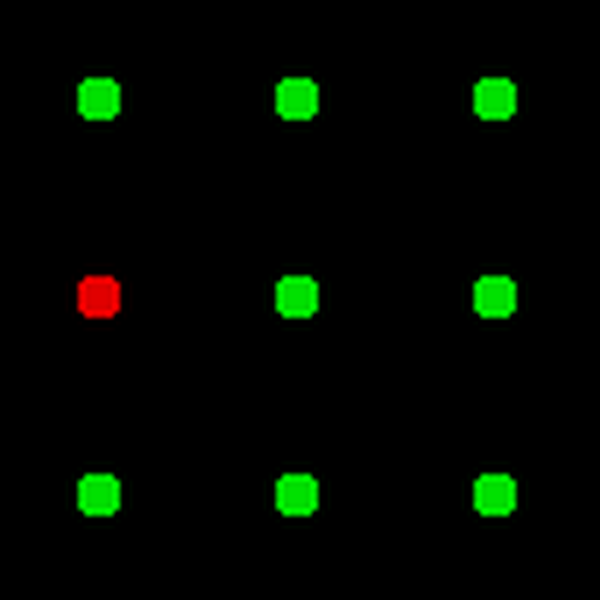

In [10]:
# my_rois = np.load('clutter_rois.npy') 
# my_rois = np.load('my_rois.npy')
# my_rois = np.load('red_popout_rois.npy') 
# my_rois = np.load('red_popout_rois_1.npy')
my_rois = np.load('grating_rois_1.npy')
# my_rois = np.load('popout_rois.npy') 
my_rois = my_rois[0,:,:]
# image = Image.new("RGB", (600, 800))
image = Image.open('/om/user/xf15/NN/project/test_popout_red_circles_on_grid/cat09image0000.png')
# image = Image.open('/om/user/xf15/NN/project/test_popout_green_circles_on_grid/cat09image0000.png')
# image = Image.open('/om/user/xf15/NN/project/test_colorful_circles_on_grid/cat09image0001.png')
# image = Image.open('/om/user/xf15/NN/project/test_colorful_circles/cat10image0000.png')
num_box = my_rois.shape[0] #300
min_rgb = 20
max_rgb = 256
# rs = np.arange(50, 256, (256-50)//(num_box/3)).astype(int)
# gs = np.arange(50, 256, (256-50)//(num_box/3)).astype(int)
# bs = np.arange(50, 256, (256-50)//(num_box/3)).astype(int)

# gs = np.repeat(0, num_box)
# bs = np.repeat(0, num_box)
small_rois = np.ndarray((1,4), dtype="float32")
for iB in range(num_box-1):
    if my_rois[iB, 3] - my_rois[iB, 1] < 80 and my_rois[iB, 3] - my_rois[iB, 1] < 80:
        small_rois = np.vstack((small_rois, my_rois[iB, 1:5]))
small_rois = small_rois[1:,:]        
num_small_rois = small_rois.shape[0] #56
rs = np.array(random.sample(range(min_rgb, max_rgb), num_small_rois))
gs = np.array(random.sample(range(min_rgb, max_rgb), num_small_rois))
bs = np.array(random.sample(range(min_rgb, max_rgb), num_small_rois))
image

In [11]:
def np_vec_no_jit_iou(boxes1, boxes2):
#     https://medium.com/@venuktan/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow-4fa16231b63d
    def run(bboxes1, bboxes2):
        x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
        x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
        xA = np.maximum(x11, np.transpose(x21))
        yA = np.maximum(y11, np.transpose(y21))
        xB = np.minimum(x12, np.transpose(x22))
        yB = np.minimum(y12, np.transpose(y22))
        interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
        boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
        boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
        iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
        return iou
    a = run(boxes1, boxes2)
    return a
b = np_vec_no_jit_iou(small_rois, small_rois)
c = b.sum(axis = 0)
d = np.where(c < 2)[0] # use mean and std
# d = np.where(c < np.mean(c) - 2 * np.std(c))[0] # use mean and std

# print(b.shape)
# print(c.shape)
# print(d.shape)

print(np.mean(c))
print(np.std(c))

# import matplotlib.pyplot as plt
# plt.imshow(b);
# plt.colorbar()
# plt.show()

5.0975666
1.247528


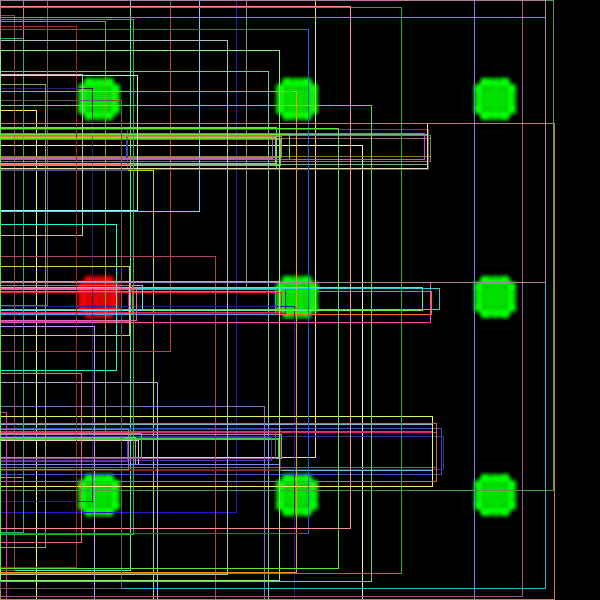

In [12]:
image1 = copy(image)
draw1 = ImageDraw.Draw(image1)
for iB in range(num_small_rois-1):
#     draw1.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
    draw1.rectangle(my_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
# image1.show()
# image1.save('temp.png')
image1

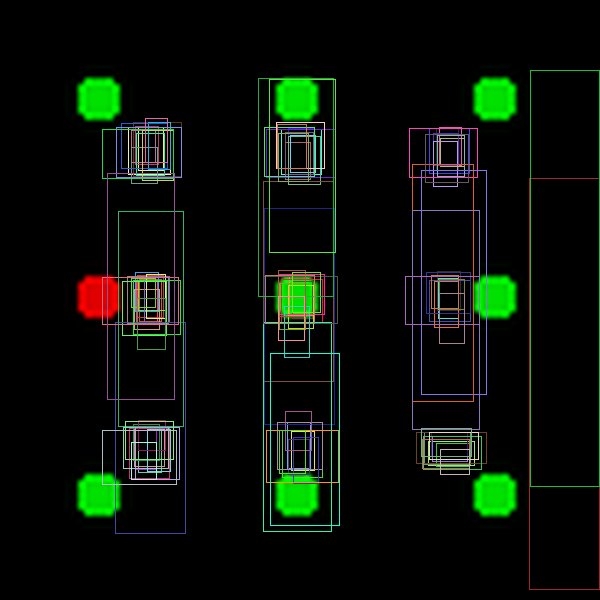

In [13]:
image2 = copy(image)
draw2 = ImageDraw.Draw(image2)
# for iB in range(num_small_rois-1):
# for iB in d:
for iB in list(set(range(num_small_rois-1)) - set(d)):
    draw2.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
# image2.show()
# image2.save('temp.png')
image2

In [8]:
my_rois.shape

(300, 5)

In [10]:
small_rois.shape

(56, 4)

In [11]:
small_rois[0,0].type

AttributeError: 'numpy.float64' object has no attribute 'type'

In [6]:
my_rois[0,:]

array([  0.     , 153.92946, 192.11487, 599.     , 599.     ],
      dtype=float32)

In [7]:
d

array([85])

(56, 56)

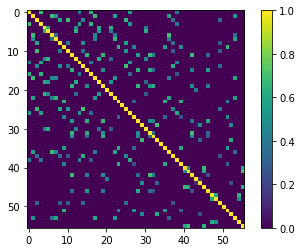

2.283283

(72, 72)
(72,)
(10,)


In [39]:
list(set(d))

[65, 35, 68, 40, 50, 51, 53, 55, 56, 59]

In [38]:
list(set(range(num_small_rois-1)) - set(d))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 52,
 54,
 57,
 58,
 60,
 61,
 62,
 63,
 64,
 66,
 67,
 69,
 70]

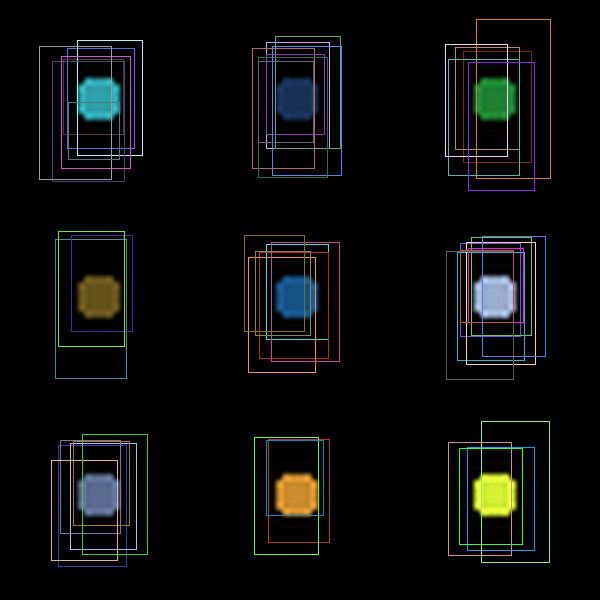

In [60]:
image2